# **Telco Customer Retention: Churn Prediction and Feedback Insights Using Classification and Topic Modelling**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from scipy import stats
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## I. Introduction

### A. Background

[Customer churn is the percentage of customers who will leave the company to the competitors. We can calculate customer churn by dividing lost customers and total customers at the start of a period, and then times it by 100 to get the percentage. Currently, the telecommunication industry is experiencing an average annual churn of 30% - 35%.](https://pdfs.semanticscholar.org/bd66/5e0db453a8ca9a344c9dccd96e700ea82cfe.pdf) [Customer churn in the telecom industry is important because when we want to bring or maintain existing customers, it is impacted the acquisition cost and retention costs. Acquisition cost is a cost of bringing new customers, and retention cost is the cost of maintaining existing customers. The acquisition cost is 5 times the retention cost. It is dangerous if we spend it on the customers that we will leave to the competitors.](https://www.sciencedirect.com/science/article/pii/S2666720723001443) Nowadays, we can predict customer churn with machine learning, analyse what customer truly wants with Natural Language Processing, and do cluster analysis on clusters that on risk of churn.

### B. Problem Statement

We know that the average customer churn for the telecommunication industry in 2025 is 30% - 35%. From the data available, our customers churn is good around 27%, but we want to improve it so it can be below 22%. With that target, we can improve the profit of Telco and stay ahead of our competitors. [In 2021, the average of customer churn was around 21%, with an economy that is already in the process of recovery from COVID-19, customer churn below 22% is achievable.](https://customergauge.com/blog/average-churn-rate-by-industry#:~:text=IT%20service%20providers%20usually%20see,is%20ideal%20for%20scaling%20businesses.) We can compare four machine learning models and use the best one between them to do hyperparameter tuning process to improve prediction of customer churn. Machine learning that we will use is Support Vector Machine, K-Nearest Neighbors, Random Forest Classifier, and XGBoost. We need to identify what influenced customers to stay to use our products. One of the solutions that can help to identify it is by doing topic modelling. We will use BERTopic models because it is one the best models for topic modelling. It can help our marketing team to analyse important topics from customers feedback. 

We will use a metric called precision score to predict not churned customers based on the actual data of not churned customers. The reason we chose this metric is that we want to minimize wrong predictions on customers that predicted not churn, but in reality the customers are churned customers.

### C. Objective

- Decrease Telco customer churn below 22%.

- Helping marketing team decide business decision to reduce customer churn.

### D. Dataset Description

| Column | Column Description |
| --- | --- |
| customerID | customer unique ID |
| gender | customers gender |
| SeniorCitizen | is the customer senior citizen or not |
| Partner | is the customer have a partner or not |
| Dependents | is the customer have relative that dependent on them or not |
| tenure | how long customers are using our products |
| PhoneService | customer subscribes to a phone service (usually landline or voice service) or not |
| MultipleLines | customer subscribes to a multiple phone service or not |
| InternetService | type of internet services that customers currently use |
| OnlineSecurity | customers subscribes to online security services or not |
| StreamingTV | customers subscribes to TV services or not |
| Contract | customers subscribes type (monthly or yearly) |
| PaperlessBilling | customers prefer paperless billing or not |
| PaymentMethod | customers prefererable payment methods |
| MonthlyCharges | customers monthly charges |
| TotalCharges | customers total charges  |
| Churn | customers leave the company or not |
| noisy_feedback | customers feedback |

## II. Data Loading

### A. Load Data

In [2]:
# load data
data = pd.read_csv('telco_noisy_feedback_prep.csv')
df = data.copy()

In [3]:
# top 10 data
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,noisy_feedback
0,7590-vhveg,female,0,yes,no,1,no,no phone service,dsl,no,no,month-to-month,yes,electronic check,29.85,29.85,0,NaN
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,one year,no,mailed check,56.95,1889.50,0,NaN
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,no,month-to-month,yes,mailed check,53.85,108.15,1,NaN
3,7795-cfocw,male,0,no,no,45,no,no phone service,dsl,yes,no,one year,no,bank transfer (automatic),42.30,1840.75,0,NaN
4,9237-hqitu,female,0,no,no,2,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.70,151.65,1,I feel like this service could be good if they...
5,9305-cdskc,female,0,no,no,8,yes,yes,fiber optic,no,yes,month-to-month,yes,electronic check,99.65,820.50,1,"At first I was happy, but over time the qualit..."
6,1452-kiovk,male,0,no,yes,22,yes,yes,fiber optic,no,yes,month-to-month,yes,credit card (automatic),89.10,1949.40,0,I feel like this service could be good if they...
7,6713-okomc,female,0,no,no,10,no,no phone service,dsl,yes,no,month-to-month,no,mailed check,29.75,301.90,0,NaN
8,7892-pookp,female,0,yes,no,28,yes,yes,fiber optic,no,yes,month-to-month,yes,electronic check,104.80,3046.05,1,NaN
9,6388-tabgu,male,0,no,yes,62,yes,no,dsl,yes,no,one year,no,bank transfer (automatic),56.15,3487.95,0,NaN


In [4]:
# bottom 10 data
df.tail(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,noisy_feedback
7022,0442-zxkvs,female,1,yes,no,54,yes,yes,fiber optic,yes,yes,one year,yes,bank transfer (automatic),115.60,6431.05,0,NaN
7023,7853-wnzsy,male,0,no,no,1,yes,no,no,no internet service,no internet service,month-to-month,yes,credit card (automatic),19.75,19.75,0,NaN
7024,3120-fazkd,male,0,yes,yes,54,yes,yes,no,no internet service,no internet service,two year,yes,bank transfer (automatic),24.05,1230.90,0,NaN
7025,8606-oegqz,female,0,no,yes,18,yes,yes,no,no internet service,no internet service,two year,no,credit card (automatic),25.30,454.65,0,NaN
7026,0225-zorzp,male,0,no,no,3,yes,no,fiber optic,no,no,month-to-month,no,electronic check,84.30,235.05,0,I feel like this service could be good if they...
7027,4702-ioqdc,female,0,no,no,1,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.10,70.10,1,NaN
7028,9489-jmttn,female,0,yes,yes,72,yes,yes,dsl,yes,yes,two year,no,credit card (automatic),89.75,6595.90,0,NaN
7029,0575-cuqov,male,1,yes,no,60,yes,no,fiber optic,no,yes,one year,yes,electronic check,97.95,5867.00,0,"I signed up because of a promo, and the pricin..."
7030,0967-bmlbd,female,0,yes,yes,11,yes,no,no,no internet service,no internet service,one year,yes,mailed check,20.00,196.35,0,NaN
7031,6178-kfnhs,female,0,no,yes,12,yes,yes,fiber optic,yes,no,month-to-month,yes,electronic check,78.30,909.25,1,NaN


### B. Data Overview

In [5]:
# check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  StreamingTV       7032 non-null   object 
 11  Contract          7032 non-null   object 
 12  PaperlessBilling  7032 non-null   object 
 13  PaymentMethod     7032 non-null   object 
 14  MonthlyCharges    7032 non-null   float64
 15  TotalCharges      7032 non-null   float64
 16  Churn             7032 non-null   int64  


In [6]:
# list of unique values

# showing maximum rows
pd.set_option('display.max_colwidth', None)

# create variable to convert table to list
df_to_list = df.to_dict('list')

# empty list for unique value table
list_unique = []

# looping for unique values table
for col, val in df_to_list.items():
    val = set(val)
    val = list(val)
    list_unique.append([col, val])

# displaying dataframe 
unique = pd.DataFrame(columns = ['col_name', 'col_unique_val'], data = list_unique)
unique


,col_name,col_unique_val
0,customerID,"[9112-wsnpu, 9191-myqkx, 5088-qzlrl, 9700-zclot, 5533-nhfrf, 0691-jvsya, 4503-bdxbd, 1710-rcxus, 6543-jxsoo, 1666-jxlku, 6418-hnfed, 8455-hiraq, 6161-uuuta, 3796-enzgf, 3967-vqogc, 2632-ucgvd, 3656-tkrvz, 9894-qmimj, 5529-gibvh, 6478-hrrcz, 2832-scuco, 8375-kvthk, 9033-eoxwv, 9289-lbqvu, 1866-obpnr, 9079-yexqj, 5716-ezxzn, 6860-yrjzp, 9479-hynyl, 5996-daoql, 4817-vyyws, 9992-ujoel, 0195-iescp, 6176-yjwas, 2359-kmgli, 5859-hzylf, 4304-tspvk, 4897-qsuyc, 9658-wyufb, 2778-oclgr, 4636-qrjky, 1135-lmecx, 8295-kmene, 7627-jkiaz, 3629-weaam, 5908-qmgoe, 5495-gpsrw, 4198-vfoea, 1137-dgowi, 3285-ucqvc, 0562-fgdcr, 7610-tvopg, 8659-ioopu, 2171-udmfd, 8773-hhuoz, 1131-qqzeb, 4043-mkdtv, 1470-psxnm, 3740-rlmvt, 0017-dinoc, 7663-rgwbc, 1251-stysz, 3120-fazkd, 9512-phsmg, 9190-mfjln, 6034-ymtob, 7398-sknqz, 9798-dryds, 4091-tvocn, 1090-eselr, 0599-xnydo, 5766-zjybb, 0795-lafgp, 0661-xeyan, 5311-ihlei, 6253-gnhwh, 2660-emubi, 7033-clamm, 0730-koave, 2740-jfbok, 6402-ejmwf, 8728-skjlr, 1271-sjbgz, 2096-xotmo, 3957-hhlmr, 1353-ghzos, 3621-chyvb, 5019-gqvcr, 0621-tssmu, 1541-etjzo, 3097-fqtvj, 4088-yldsu, 3797-fkogq, 8361-ltmkd, 7537-cbquz, 7683-cbdkj, 6728-wyqbc, 4636-olwoe, 0454-okrct, 9174-ihetn, ...]"
1,gender,"[female, male]"
2,SeniorCitizen,"[0, 1]"
3,Partner,"[yes, no]"
4,Dependents,"[yes, no]"
5,tenure,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]"
6,PhoneService,"[yes, no]"
7,MultipleLines,"[yes, no phone service, no]"
8,InternetService,"[dsl, fiber optic, no]"
9,OnlineSecurity,"[no internet service, yes, no]"


In [7]:
# check total missing value
print(f"Total missing value in the data: {df.isnull().sum().sum()}")

Total missing value in the data: 5228


In [8]:
# check which column has missing value
df.isnull().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
StreamingTV            0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
noisy_feedback      5228
dtype: int64

### C. Change Columns Name

In [9]:
# check columns name
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'StreamingTV', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'noisy_feedback'],
      dtype='object')

In [10]:
# change columns name
df.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'streaming_tv', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'customer_feedback']
df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'streaming_tv', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'customer_feedback'],
      dtype='object')

In [11]:
# check table
df

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
0,7590-vhveg,female,0,yes,no,1,no,no phone service,dsl,no,no,month-to-month,yes,electronic check,29.85,29.85,0,NaN
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,one year,no,mailed check,56.95,1889.50,0,NaN
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,no,month-to-month,yes,mailed check,53.85,108.15,1,NaN
3,7795-cfocw,male,0,no,no,45,no,no phone service,dsl,yes,no,one year,no,bank transfer (automatic),42.30,1840.75,0,NaN
4,9237-hqitu,female,0,no,no,2,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.70,151.65,1,"I feel like this service could be good if they just improved communication. The product is alright, but I never get emails or updates. When I do, they’re overly technical. Would love a more customer-friendly approach."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,4702-ioqdc,female,0,no,no,1,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.10,70.10,1,NaN
7028,9489-jmttn,female,0,yes,yes,72,yes,yes,dsl,yes,yes,two year,no,credit card (automatic),89.75,6595.90,0,NaN
7029,0575-cuqov,male,1,yes,no,60,yes,no,fiber optic,no,yes,one year,yes,electronic check,97.95,5867.00,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
7030,0967-bmlbd,female,0,yes,yes,11,yes,no,no,no internet service,no internet service,one year,yes,mailed check,20.00,196.35,0,NaN


### D. Change Columns Value

In [12]:
# change value in senior_citizen column
df.senior_citizen = df.senior_citizen.replace({1: 'yes', 0: 'no'})
df

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
0,7590-vhveg,female,no,yes,no,1,no,no phone service,dsl,no,no,month-to-month,yes,electronic check,29.85,29.85,0,NaN
1,5575-gnvde,male,no,no,no,34,yes,no,dsl,yes,no,one year,no,mailed check,56.95,1889.50,0,NaN
2,3668-qpybk,male,no,no,no,2,yes,no,dsl,yes,no,month-to-month,yes,mailed check,53.85,108.15,1,NaN
3,7795-cfocw,male,no,no,no,45,no,no phone service,dsl,yes,no,one year,no,bank transfer (automatic),42.30,1840.75,0,NaN
4,9237-hqitu,female,no,no,no,2,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.70,151.65,1,"I feel like this service could be good if they just improved communication. The product is alright, but I never get emails or updates. When I do, they’re overly technical. Would love a more customer-friendly approach."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,4702-ioqdc,female,no,no,no,1,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.10,70.10,1,NaN
7028,9489-jmttn,female,no,yes,yes,72,yes,yes,dsl,yes,yes,two year,no,credit card (automatic),89.75,6595.90,0,NaN
7029,0575-cuqov,male,yes,yes,no,60,yes,no,fiber optic,no,yes,one year,yes,electronic check,97.95,5867.00,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
7030,0967-bmlbd,female,no,yes,yes,11,yes,no,no,no internet service,no internet service,one year,yes,mailed check,20.00,196.35,0,NaN


In [13]:
# save fix data
df.to_csv('fix-data.csv', index=False)

## III. Exploratory Data Analysis

In [14]:
# temporary fill missing value with "No Feedback"
df_eda = df.copy()
df_eda = df_eda.fillna(value={'customer_feedback':'No Feedback'})
df_eda

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
0,7590-vhveg,female,no,yes,no,1,no,no phone service,dsl,no,no,month-to-month,yes,electronic check,29.85,29.85,0,No Feedback
1,5575-gnvde,male,no,no,no,34,yes,no,dsl,yes,no,one year,no,mailed check,56.95,1889.50,0,No Feedback
2,3668-qpybk,male,no,no,no,2,yes,no,dsl,yes,no,month-to-month,yes,mailed check,53.85,108.15,1,No Feedback
3,7795-cfocw,male,no,no,no,45,no,no phone service,dsl,yes,no,one year,no,bank transfer (automatic),42.30,1840.75,0,No Feedback
4,9237-hqitu,female,no,no,no,2,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.70,151.65,1,"I feel like this service could be good if they just improved communication. The product is alright, but I never get emails or updates. When I do, they’re overly technical. Would love a more customer-friendly approach."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,4702-ioqdc,female,no,no,no,1,yes,no,fiber optic,no,no,month-to-month,yes,electronic check,70.10,70.10,1,No Feedback
7028,9489-jmttn,female,no,yes,yes,72,yes,yes,dsl,yes,yes,two year,no,credit card (automatic),89.75,6595.90,0,No Feedback
7029,0575-cuqov,male,yes,yes,no,60,yes,no,fiber optic,no,yes,one year,yes,electronic check,97.95,5867.00,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
7030,0967-bmlbd,female,no,yes,yes,11,yes,no,no,no internet service,no internet service,one year,yes,mailed check,20.00,196.35,0,No Feedback


### A. Correlation Between Numerical Columns to Churn

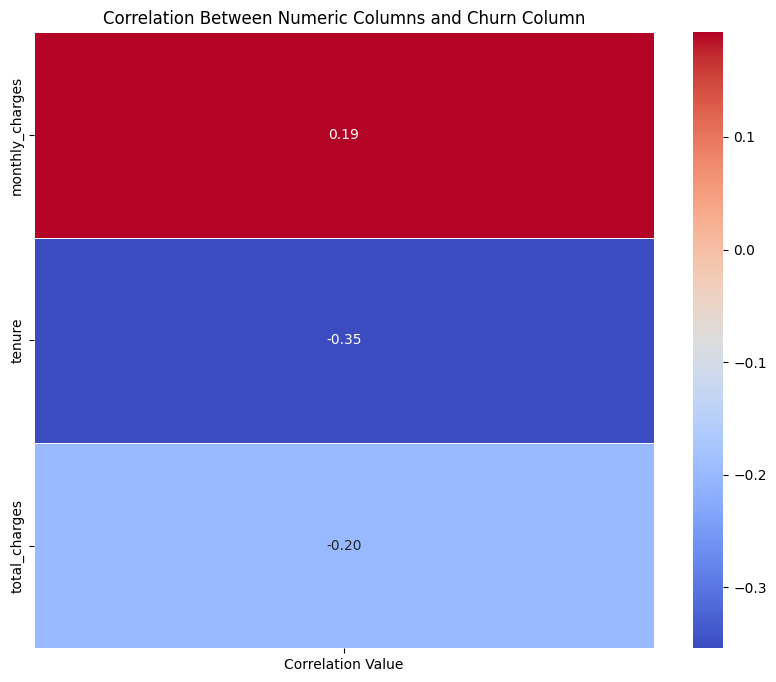

In [15]:
# check correlation of every column to churn
continous_col = df_eda.columns.difference(['churn', 'contract', 'customer_feedback', 'customer_id','dependents',
                                            'gender', 'internet_service', 'multiple_lines','online_security',
                                            'paperless_billing', 'partner', 'payment_method',
                                            'phone_service', 'senior_citizen', 'streaming_tv'])
corr_dict = {}

for col in continous_col:
    corr, _ = stats.pointbiserialr(df_eda['churn'], df_eda[col])
    corr_dict[col] = corr

# convert to dataframe
corr_df = pd.DataFrame.from_dict(corr_dict, orient = 'index', columns = ['Correlation Value'])

# visualise it
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, annot=True, 
            cmap='coolwarm', 
            fmt='.2f',
            linewidths=0.5)
plt.title('Correlation Between Numeric Columns and Churn Column')
plt.show()

Explanations:

[Based on the correlation heatmap above, we can see that customer monthly charges and customer total charges have a weak correlation to influence customer churn, and customer tenure has a moderate correlation to customer churn. Tenure and customer total charges have a negative correlation value. It means that the longer customers stay to use our products and the higher the total charges, the higher the chance that our customers to not leave our company. Customers monthly charges have a positive correlation value. It means that the higher the monthly charges, there's a higher chance that customers to leave our company.](https://www.researchgate.net/publication/380818110/figure/tbl2/AS:11431281246850668@1716510726033/Correlation-Coefficient-interpretation-table.png)

Tenure has the most influence among the three of them since customers monthly charges and customers total charges have a weak correlation to churn. We can focus more on improving tenure to reduce customer churn. To improve our customers tenure, we can check the correlation between tenure and all of the columns in the data.

### B. Correlation Between All Columns to Tenure

In [16]:
# looping to determine type of distribution

num_cols_eda = ['monthly_charges', 'total_charges', 'tenure']

# empty list for outlier table
list_col1 = []

# looping for determining the outlier
for col in num_cols_eda:
    list_col1.append([col, round(df_eda[col].skew(),1), np.where(0.5 >= df_eda[col].skew() >= -0.5,
                                                                      'normal', 'skewed')])

# store it to variable and display it   
skewness = pd.DataFrame(columns = ['col_name', 'skew_value', 'distribution_type'], data = list_col1)
skewness

,col_name,skew_value,distribution_type
0,monthly_charges,-0.2,normal
1,total_charges,1.0,skewed
2,tenure,0.2,normal


In [17]:
# pearson corr test for columns with normal distribution 
corr, _ = stats.pearsonr(df_eda.monthly_charges, df_eda.tenure)
print(f"Correlation value customer monthly charges to tenure: {corr}")

# spearman corr test for columns with one of them
# has skewed distribution 
corr, _ = stats.spearmanr(df_eda.total_charges, df_eda.tenure)
print(f"Correlation value customer total charges to tenure: {corr}")

Correlation value customer monthly charges to tenure: 0.2468617666408935
Correlation value customer total charges to tenure: 0.8891770805365491


Explanation:

[Based on the correlation value above, we can see that customer monthly charges have a weak correlation to customer tenure, and customer total charges have a very strong correlation to customer tenure. Because customer total charges have a strong and positive correlation to customer tenure, we can conclude that the higher the total customer charges, the longer customers stay using our services.](https://www.researchgate.net/publication/380818110/figure/tbl2/AS:11431281246850668@1716510726033/Correlation-Coefficient-interpretation-table.png)

In [18]:
df_eda.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'streaming_tv', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'customer_feedback'],
      dtype='object')

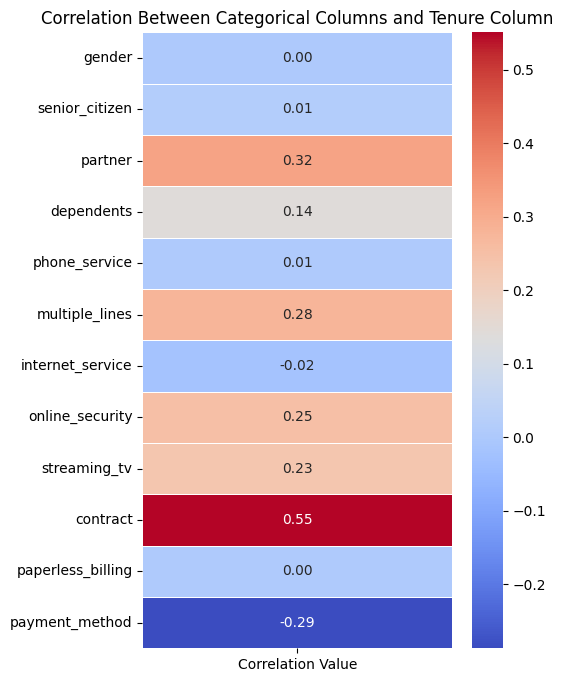

In [19]:
# check correlation of every column to tenure
non_cont_col = df_eda[['gender', 'senior_citizen', 'partner', 'dependents', 
                        'phone_service', 'multiple_lines', 'internet_service',
                        'online_security', 'streaming_tv', 'contract', 
                        'paperless_billing','payment_method']]
corr_dict = {}

# we use kendall correlation test because we gonna check correlation
# between categorical to numerical columns
for col in non_cont_col:
    corr, _ = stats.kendalltau(df_eda[col], df_eda['tenure'])
    corr_dict[col] = corr

# convert to dataframe
corr_df = pd.DataFrame.from_dict(corr_dict, orient = 'index', columns = ['Correlation Value'])

# visualise it
plt.figure(figsize=(5,8))
sns.heatmap(corr_df, annot=True, 
            cmap='coolwarm', 
            fmt='.2f',
            linewidths=0.5)
plt.title('Correlation Between Categorical Columns and Tenure Column')
plt.show()

Explanation:

Based on heatmap correlation above, customer contract type have strong correlation to customer tenure. Customer has a partner or not and customers payment method type have moderate correlation to customer tenure. We can focus our attention to customer contract type to improve our customer tenure, and then we can focus on how customer has a partner or not and payment method type influence to customer tenure.

### C. Distribution of Tenure Based On Customer Contract Type

In [20]:
# filter based on contract per two year
df_eda_c_twoyear = df_eda[df_eda.contract == 'two year']
df_eda_c_twoyear

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
11,7469-lkbci,male,no,no,no,16,yes,no,no,no internet service,no internet service,two year,no,credit card (automatic),18.95,326.80,0,No Feedback
15,3655-snqyz,female,no,yes,yes,69,yes,yes,fiber optic,yes,yes,two year,no,credit card (automatic),113.25,7895.15,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
17,9959-wofkt,male,no,no,yes,71,yes,yes,fiber optic,yes,yes,two year,no,bank transfer (automatic),106.70,7382.25,0,No Feedback
23,3638-weabw,female,no,yes,no,58,yes,yes,dsl,no,no,two year,yes,credit card (automatic),59.90,3505.10,0,No Feedback
28,5248-ygijn,male,no,yes,no,72,yes,yes,dsl,yes,yes,two year,yes,credit card (automatic),90.25,6369.45,0,No Feedback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7015,3873-wosbc,male,no,yes,no,67,yes,yes,no,no internet service,no internet service,two year,no,credit card (automatic),25.60,1784.90,0,No Feedback
7017,7975-jmznt,male,no,yes,no,66,yes,yes,dsl,yes,yes,two year,no,bank transfer (automatic),91.70,6075.90,0,"They were helpful, but the bill confused me. I’m not cancelling just yet, but I’ll reconsider if this happens again. The service itself works, but I feel like I’m missing something."
7024,3120-fazkd,male,no,yes,yes,54,yes,yes,no,no internet service,no internet service,two year,yes,bank transfer (automatic),24.05,1230.90,0,No Feedback
7025,8606-oegqz,female,no,no,yes,18,yes,yes,no,no internet service,no internet service,two year,no,credit card (automatic),25.30,454.65,0,No Feedback


Text(0.5, 1.0, 'Tenure Distribution on Customer with Two Year Contract')

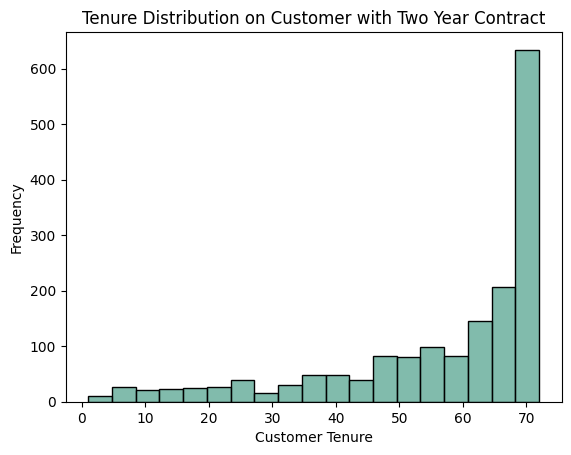

In [ ]:
# visualise it
sns.histplot(data = df_eda_c_twoyear, x = 'tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Tenure Distribution on Customer with Two Year Contract')

Text(0.5, 1.0, 'Tenure Distribution on Customer with One Year Contract')

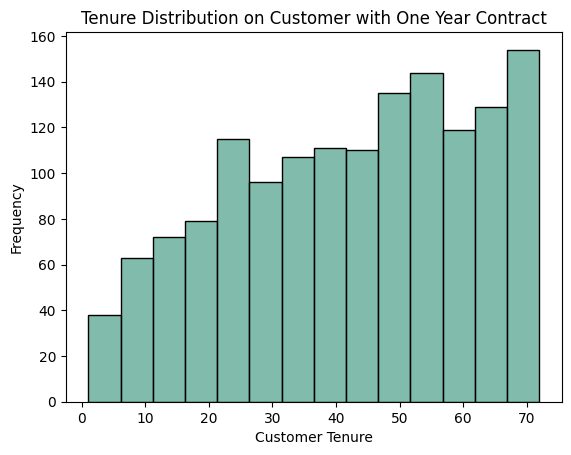

In [22]:
# filter based on contract per one year
df_eda_c_oneyear = df_eda[df_eda.contract == 'one year']

# visualise it
sns.histplot(data = df_eda_c_oneyear, x = 'tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Tenure Distribution on Customer with One Year Contract')

Text(0.5, 1.0, 'Tenure Distribution on Customer with Month-to-Month Contract')

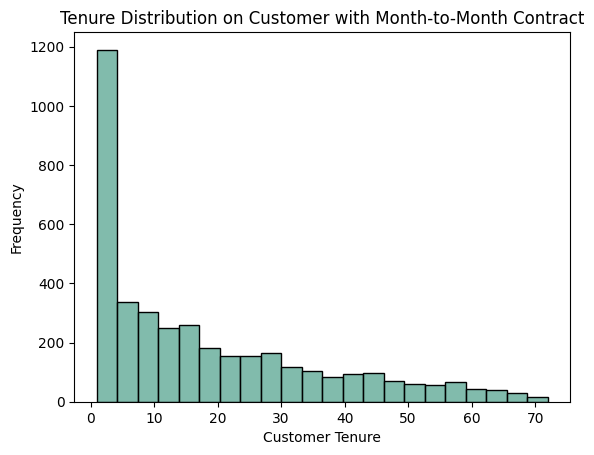

In [23]:
# filter based on contract month to month
df_eda_c_month = df_eda[df_eda.contract == 'month-to-month']

# visualise it
sns.histplot(data = df_eda_c_month, x = 'tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Tenure Distribution on Customer with Month-to-Month Contract')

Explanations:

Based on the tenure distribution for each customer contract type, we can see that customers with a two-year contract type have the most customers in the range between 65-72 months. Customers with shorter tenure are mostly low on this histogram. Most customers on customers with a one-year contract type are in the range between 52-58 months. This histogram has a quite mixed spread of customers between shorter and longer tenure. Tenure distribution of customers with month-to-month contract type has its most customers in the range between 2-6 months. Customers with this contract type have a shorter tenure than the other two contract types. The frequency of customers with month-to-month contract type is the largest than the other customers.

From that analysis, we can conclude that we have the potential to improve customers with one-year contract type. We need to improve the number of customers on the longer tenure and decrease customers on shorter tenure on customers with this contract type.

### D. Distribution of Tenure Based On Whether Customers Have Partner or Not

Text(0.5, 1.0, 'Tenure Distribution on Customer Who Have a Partner')

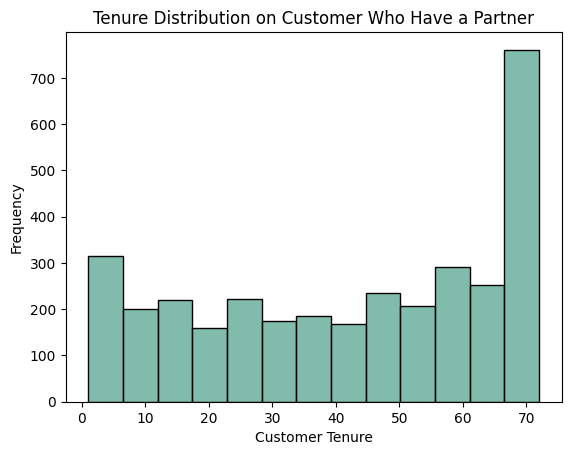

In [24]:
# filter based on contract per one year and customer
# have a partner
df_eda_d_yes = df_eda[df_eda.partner == 'yes']

# visualise it
sns.histplot(data = df_eda_d_yes, x = 'tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency') 
plt.xlabel('Customer Tenure')
plt.title('Tenure Distribution on Customer Who Have a Partner')

Text(0.5, 1.0, "Tenure Distribution on Customer Who Doesn't Have a Partner")

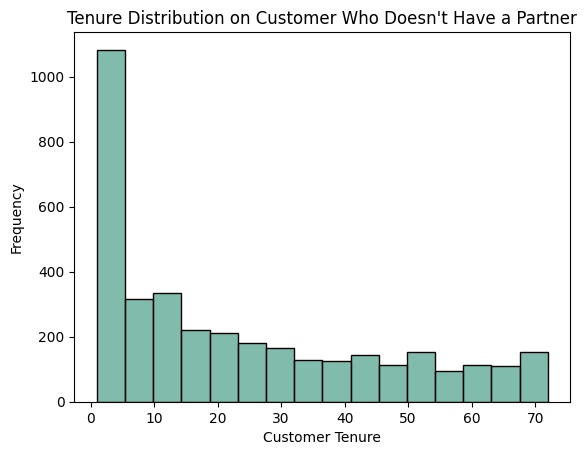

In [25]:
# filter based on contract per one year and customer
# have a partner
df_eda_d_no = df_eda[df_eda.partner == 'no']

# visualise it
sns.histplot(data = df_eda_d_no, x = 'tenure',color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Tenure Distribution on Customer Who Doesn\'t Have a Partner')

Explanation:

Based on histogram above, tenure on customers that has a partner have their most customers on the range between 65-72 months. Most of the customers on this type of customer are long=term loyalty. Customers who don't have a partner have their most customers on the tenure range between 1-9 months. Customer with this type mostly are customer with short-term loyalty.

From the analysis, we can conclude that we need to improve our customer tenure on customer that have a partner, because we can decrease the the number of short-term customers that on the range between 1-24 months.

### E. Customer Comparison Based On Payment Method

In [26]:
# create table grouping by payment methpd
df_eda_e = df_eda.groupby('payment_method')['customer_id'].count().reset_index()
df_eda_e.rename(columns={'customer_id': 'total_customer'}, inplace=True)
df_eda_e

,payment_method,total_customer
0,bank transfer (automatic),1542
1,credit card (automatic),1521
2,electronic check,2365
3,mailed check,1604


C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\3794380280.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_eda_e, x='total_customer', y='payment_method', palette=palette)


Text(0.5, 1.0, 'Customer Payment Method Comparison')

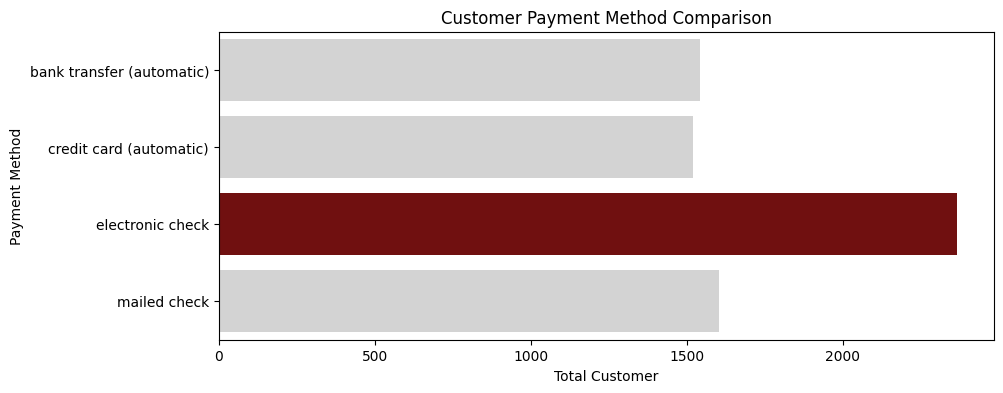

In [27]:
# find the highest most customer
top_method = df_eda_e.loc[df_eda_e.total_customer.idxmax(), 'payment_method']

# build palette with the most ne with color and the other with grey
methods = df_eda_e.payment_method
palette = {method: 'maroon' if method == top_method else 'lightgray' for method in methods}

# visualization with bar chart
plt.figure(figsize=(10,4))

sns.barplot(data=df_eda_e, x='total_customer', y='payment_method', palette=palette)
plt.ylabel('Payment Method')
plt.xlabel('Total Customer')
plt.title('Customer Payment Method Comparison')

Explanation:

Based on the bar chart above, customers prefer to make payment with electronic check. Payment with credit card that automatically decrease bank balance is the least preferable for our customers. Both bank transfer and credit card payment system automatically decrease bank balance customers account. The reason why both of them is the least preferable option, because not all of our customers have credit card, and payment that automatically decrease bank balance made customers unable to plan their household bills.

### F. Distribution of Tenure Based On Customer Payment Method

Text(0.5, 1.0, 'Distribution of Tenure With Mailed Check Payment')

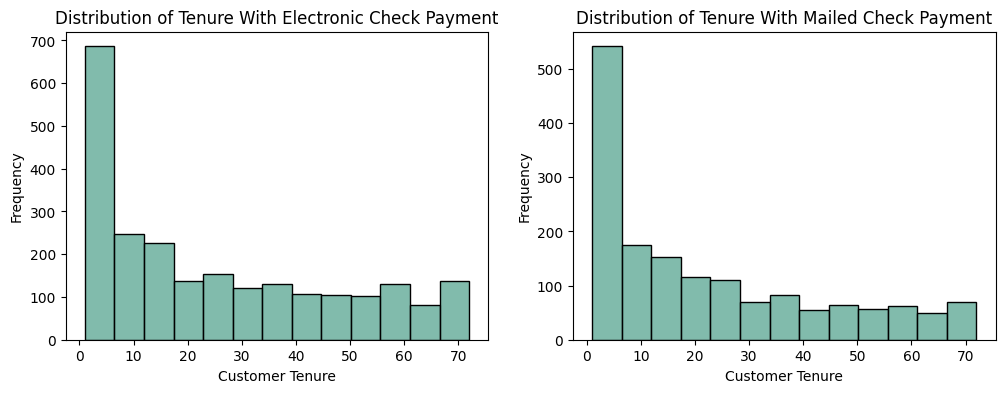

In [28]:
# filter based on electronic check payment method
df_eda_ec = df_eda[df_eda.payment_method == 'electronic check']

# filter based on credit card payment method
df_eda_mc = df_eda[df_eda.payment_method == 'mailed check']

# visualise it
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df_eda_ec, x='tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Distribution of Tenure With Electronic Check Payment')

plt.subplot(1, 2, 2)
sns.histplot(data=df_eda_mc, x='tenure',color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Distribution of Tenure With Mailed Check Payment')

Text(0.5, 1.0, 'Distribution of Tenure With Credit Card (Automatic) Payment')

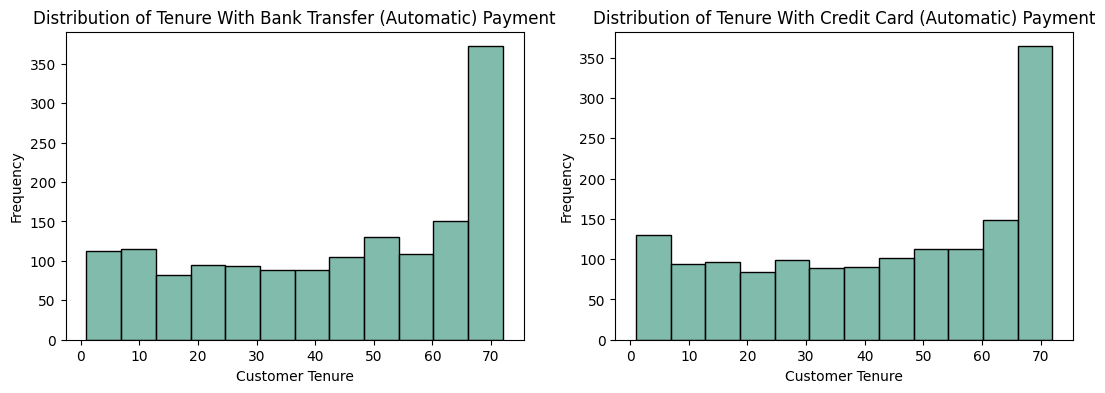

In [29]:
# filter based on bank transfer payment method
df_eda_bt = df_eda[df_eda.payment_method == 'bank transfer (automatic)']

# filter based on credit card payment method
df_eda_cc = df_eda[df_eda.payment_method == 'credit card (automatic)']

# visualise it
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df_eda_bt, x='tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Distribution of Tenure With Bank Transfer (Automatic) Payment')

plt.subplot(1, 2, 2)
sns.histplot(data=df_eda_cc, x='tenure', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Frequency')
plt.xlabel('Customer Tenure')
plt.title('Distribution of Tenure With Credit Card (Automatic) Payment')

Explanation:

Customers who make their payments with bank transfers and credit cards have their largest total customers in the tenure range between 65-72 months. Most of the customers with both payment methods are customers with long-term loyalty. Customers who make their payment with electronic checks and mail checks have their largest total customers in the tenure range between 1-9 months. Most of the customers who make their payments with electronic and mailed checks are customers with short-term loyalty.

[We can use this as an indicator where we can monitor improvement in customer loyalty based on the payment method they choose. Customers who use automatic payment means our services are priorities to them. We want more customers who will make their payments using automatic payment either bank transfer or credit card, because most of the customers using their payment have long-term loyalty.](https://www.aeaweb.org/conference/2023/program/paper/rNDY23Q6)

### G. Correlation Between Categorical Columns to Churn

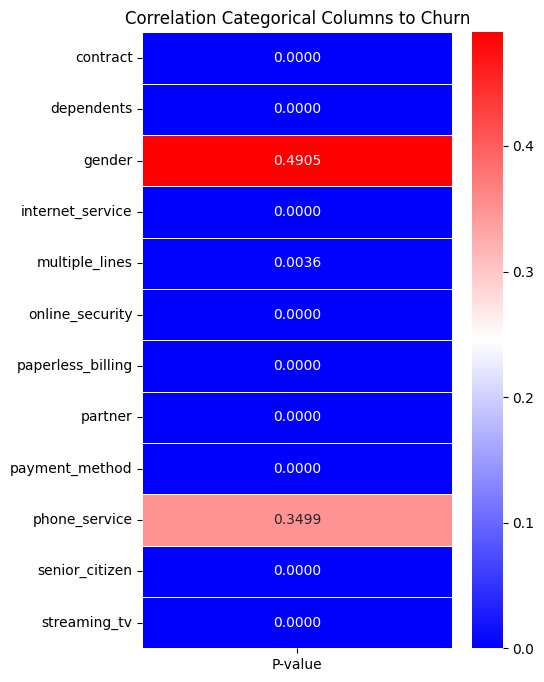

In [30]:
# check correlation of categorical column to churn
categorical_col = df_eda[['contract','dependents','gender', 'internet_service', 
                          'multiple_lines','online_security','paperless_billing','partner', 'payment_method',
                          'phone_service', 'senior_citizen', 'streaming_tv']]
pvalue_dict = {}

for col in categorical_col:
    contingency_table = pd.crosstab(df_eda[col],df_eda['churn'])
    res = stats.chi2_contingency(contingency_table)
    pvalue_dict[col] = res.pvalue

# convert to dataframe
corr_df = pd.DataFrame.from_dict(pvalue_dict, orient = 'index', columns = ['P-value'])

# visualise it
plt.figure(figsize=(5,8))
sns.heatmap(corr_df, annot=True, 
            cmap='bwr', 
            fmt='.4f',
            linewidths=0.5)
plt.title('Correlation Categorical Columns to Churn')
plt.show()

Explanation:

We use the chi-squared test to measure a correlation between the categorical column and to churn column. From the calculation, we found that gender and phone_service p-value are bigger than the critical value (critical value is 0.05). It means that customer gender and customers using phone service or not are not influenced by customer churn. On the other hand, the contract, dependents, internet_service, multiple_lines, online_security, paperless_billing, partner, payment_method, senior_citizen, and streaming_tv columns are correlated to the churn column, because their p-value is smaller than the critical value.

From this, we can identify problems and read the patterns that can make customers leave the company.

### H. Percentage of Churned Customers and Not

Text(0.5, 1.0, 'Percentage of Churned Customers and Not')

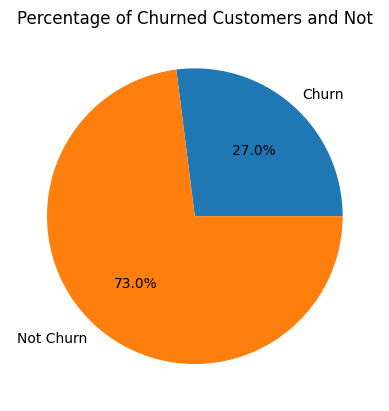

In [31]:
# create churn table
df_churn = df_eda.groupby('churn')['customer_id'].count().reset_index()
df_churn.rename(columns={'customer_id': 'total_customers'}, inplace=True)
df_churn_1 = df_churn[df_churn.churn == 1]
df_churn_0 = df_churn[df_churn.churn == 0]

# percentage between churn or not
churn_p = (sum(df_churn_1.total_customers)/sum(df_churn.total_customers)) * 100
not_churn_p = (sum(df_churn_0.total_customers)/sum(df_churn.total_customers)) * 100

# create labels and sizes parameter
labels = 'Churn', 'Not Churn'
sizes = [round(churn_p), round(not_churn_p)]

# plotting pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Churned Customers and Not')

Explanations:

[Based on the pie chart above, 73% of our customers are not churned and 27% are churned. Average of customer churn for telecommunication industry on 2025 are 31%, so we are below it. The target that we set to decrease the churn rate to below 22% is realistic and can be achieved.](https://customergauge.com/blog/average-churn-rate-by-industry#:~:text=Telecom%20churn%20averages%2015%E2%80%9325,price%20sensitivity%2C%20and%20customer%20experience.)

### I. Comparison of Churned Based on Contract Type

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\3689673348.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churned_contract, x='contract', y='churn', palette=palette)


Text(0.5, 1.0, 'Comparison Churned Customers Contract Type')

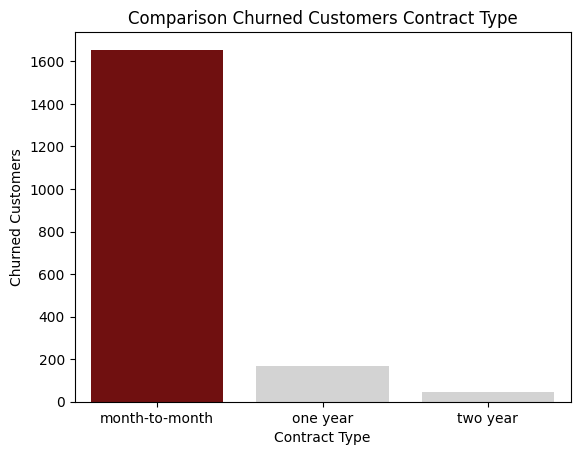

In [32]:
# filter by churned customers
df_churned = df_eda[df_eda.churn == 1]
churned_contract = df_churned.groupby('contract')['churn'].count().reset_index()

# find the highest most customer
top_method = churned_contract.loc[churned_contract.churn.idxmax(), 'contract']

# build palette with the most ne with color and the other with grey
methods = churned_contract.contract
palette = {method: 'maroon' if method == top_method else 'lightgray' for method in methods}

# visualise it 
sns.barplot(data=churned_contract, x='contract', y='churn', palette=palette)
plt.ylabel('Churned Customers')
plt.xlabel('Contract Type')
plt.title('Comparison Churned Customers Contract Type')

Explanation:

Based on the comparison above, we can see that most of our churned customers are month-to-month customers. It can happen because customers with month-to-month are trial customers and customers that are still unsure if it's worth continuing for the longer term. We need to improve this by converting customers on month-to-month contracts to one-year contracts.

### J. Comparison of Churned Customers Based on Dependents

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\314110950.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churned_dependents, x='dependents', y='churn', palette={'no': '#301934', 'yes': '#CEA2FD'})


Text(0.5, 1.0, 'Comparison Churned Customers Having Dependents or Not')

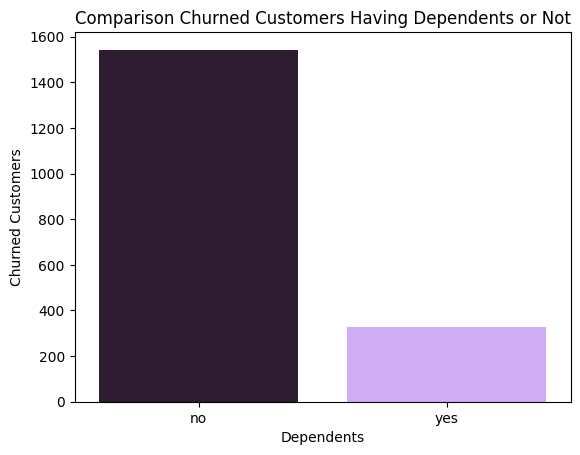

In [33]:
# filter by churned customers based on dependents
churned_dependents = df_churned.groupby('dependents')['churn'].count().reset_index()

# visualise it 
sns.barplot(data=churned_dependents, x='dependents', y='churn', palette={'no': '#301934', 'yes': '#CEA2FD'})
plt.ylabel('Churned Customers')
plt.xlabel('Dependents')
plt.title('Comparison Churned Customers Having Dependents or Not')

Explanation:

We can see that mostly churned customers are customer who don't have dependents. Customer who don't have dependents either still a single or have partner but doesn't have kids. We analyse this before on tenure distribution based on customer who have partner or not, and the result is customer who doesn't have a partner tend to be a customer with short-term loyalty. We can consider to prioritise more on customers who have a partner and customers who have dependents and a partner.

### K. Comparison of Senior Citizen

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\2623540761.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churned_senior, x='senior_citizen', y='churn', palette={'no': '#301934', 'yes': '#CEA2FD'})


Text(0.5, 1.0, 'Senior Customer Comparison Based on Paperless Billing')

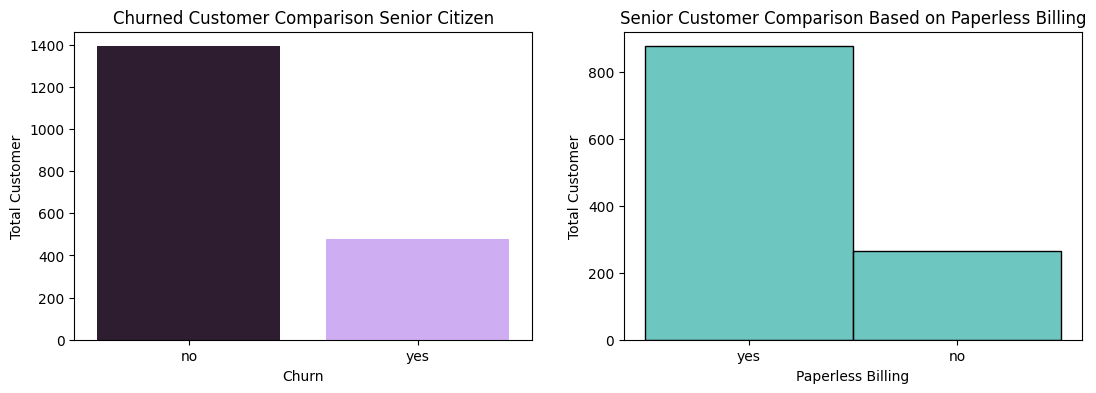

In [34]:
# filter by churned customers based on streaming tv
churned_senior = df_churned.groupby('senior_citizen')['churn'].count().reset_index()

# filter by only senior citizen and determine 
# if they prefer paperless billing or not
senior = df_eda[df_eda.senior_citizen == 'yes']

# visualise it
plt.figure(figsize=(13,4))

plt.subplot(1, 2, 1)
sns.barplot(data=churned_senior, x='senior_citizen', y='churn', palette={'no': '#301934', 'yes': '#CEA2FD'})
plt.ylabel('Total Customer')
plt.xlabel('Churn')
plt.title('Churned Customer Comparison Senior Citizen')

plt.subplot(1, 2, 2)
sns.histplot(data=senior, x='paperless_billing', color=sns.color_palette("mako", as_cmap=True)(0.7))
plt.ylabel('Total Customer')
plt.xlabel('Paperless Billing')
plt.title('Senior Customer Comparison Based on Paperless Billing')

Explanation:

The chart on the left is churned customer comparison of senior citizens. We can see that we have good customer retention for customers who are categorised as senior citizens. The chart on the right is a comparison of senior customers based on whether they prefer paperless billing or not, since in general senior citizens have the tendency to paper billing. For our senior customers, we found that they prefer paperless billing. We can conclude that our billing system is senior-friendly and we can continue to improve that in the future.

### L. Comparison Senior Customer Based on Paperless Billing

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\1280173968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_eda, x='partner', y='churn', palette={'no': '#301934', 'yes': '#CEA2FD'})


Text(0.5, 1.0, 'Churned Customer Based On Customer Have Partner or Not')

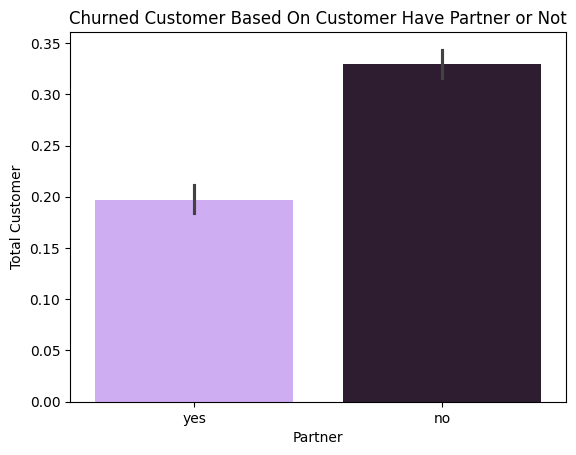

In [35]:
# visualisation 
sns.barplot(data=df_eda, x='partner', y='churn', palette={'no': '#301934', 'yes': '#CEA2FD'})
plt.ylabel('Total Customer')
plt.xlabel('Partner')
plt.title('Churned Customer Based On Customer Have Partner or Not')

Explanation:

Based on the bar chart above, customers who don't have a partner are likely to churn that customers who have a partner. It is aligned with our analysis of tenure distribution based on customers who have a partner or not. [Single customers are more likely to have short-term loyalty. It is influenced by single customers who are prone to moving a lot, so they have the tendency to change providers a lot too. The reason they move is that they are either not interested in marriage or still searching for a partner.](https://www.emerald.com/insight/content/doi/10.1108/07363760710773085/full/html)

### M. Comparison of Churned Customers Based On Have Antivirus or Not

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\170888287.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_eda, x = 'online_security', y = 'churn', palette = palette)


Text(0.5, 1.0, 'Churned Customers Based on Have Antivirus or Not')

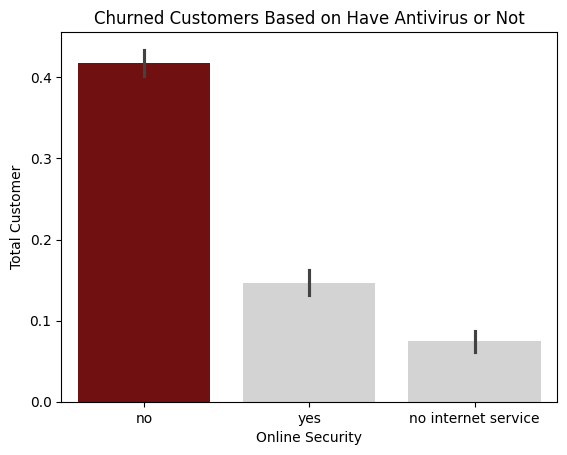

In [36]:
# group by online_security column
df_secure = df_eda.groupby('online_security')['churn'].sum().reset_index()

# visualise it

# find the highest most customer
top_method = df_secure.loc[df_secure.churn.idxmax(), 'online_security']

# build palette with the most ne with color and the other with grey
methods = df_eda.online_security
palette = {method: 'maroon' if method == top_method else 'lightgray' for method in methods}

# configure the visualisation
sns.barplot(data = df_eda, x = 'online_security', y = 'churn', palette = palette)
plt.ylabel('Total Customer')
plt.xlabel('Online Security')
plt.title('Churned Customers Based on Have Antivirus or Not')

In [37]:
# filter churned customer based on not having antivirus
df_secure_no = df_eda[df_eda.online_security == 'no']

# check feedback with "security" word
df_eda[df_eda.customer_feedback.str.contains('security', case=False, na=False)].head(10)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback


Explanation:

Based on the bar chart above, customers who don't have antivirus are likely to churn. If we check feedback about security on our data, we don't find anything mentioning our security product. It means that it just happens customers who don't subscribe to our antivirus product are the most churned customers.

### N. Distribution of Monthly Charges of Churned Customers

Text(0.5, 1.0, 'Distribution of Monthly Charges Churned Customers')

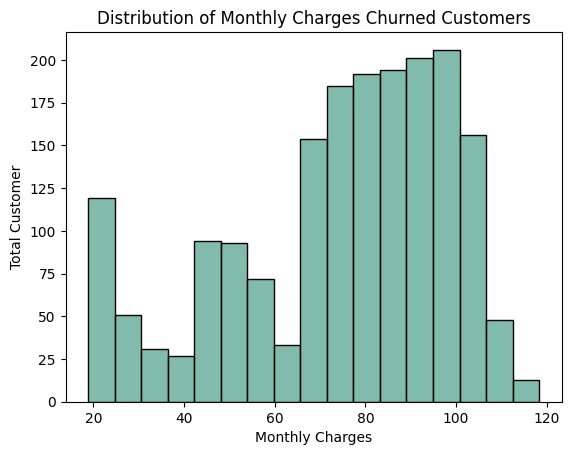

In [38]:
# make a copy of df_eda
df_charges_churn = df_eda[df_eda.churn == 1]

# visualise it
sns.histplot(data=df_charges_churn, x='monthly_charges', color=sns.color_palette("crest", as_cmap=True)(0.3))
plt.ylabel('Total Customer')
plt.xlabel('Monthly Charges')
plt.title('Distribution of Monthly Charges Churned Customers')

In [39]:
# filter churned customers based on row contain word "charges"
df_charges_churn[df_charges_churn.customer_feedback.str.contains('charges', case=False, na=False)]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
13,0280-xjgex,male,no,no,no,49,yes,yes,fiber optic,no,yes,month-to-month,yes,bank transfer (automatic),103.70,5036.30,1,"i recently decided to switch internet providers after being with my previous provider for almost four years. while the fiber optic internet service was reliable and fast, the monthly charges of $103.70 were a bit steep for me, especially since i was on a month-to-month contract. the automatic bank transfer payment method was convenient, but ultimately i decided to shop around for a more cost-effective option. overall, i had a positive experience with the service itself, but the pricing ultimately led me to churn."
151,3874-eqoep,male,no,no,no,7,yes,yes,fiber optic,no,yes,month-to-month,no,mailed check,95.00,655.50,1,"i was a customer with this company for 7 months on a month-to-month contract. i chose to pay my $95.0 monthly charges by mailing a check. unfortunately, i ultimately decided to churn as i found a better deal with another provider. the fiber optic internet service was reliable during my time with the company, but ultimately the cost was a deciding factor in my decision to leave. i would recommend this company to others looking for a reliable internet service, but would caution them to compare prices with other providers to ensure they are getting the best deal."
173,0691-jvsya,female,no,yes,no,53,yes,no,fiber optic,no,yes,one year,yes,bank transfer (automatic),94.85,5000.20,1,"i have been a customer with this company for 53 months and have been using their fiber optic internet service. i have been satisfied with the service itself, as the speeds have been consistent and reliable. however, i recently decided to churn because i found a better deal with another provider. the monthly charges of $94.85 were reasonable for the service provided, but i ultimately chose to switch due to a more competitive offer. the automatic bank transfer payment method was convenient and hassle-free. overall, i had a positive experience with this company, but decided to leave for a better deal."
637,7817-boqpw,female,no,no,no,2,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,75.55,166.30,1,"""after only 2 months of using the fiber optic internet service, i decided to cancel due to ongoing technical issues and unreliable connection. despite the relatively high monthly charges of $75.55, the service did not meet my expectations. i also found the payment method of electronic check to be inconvenient and would have preferred more options. overall, i was disappointed with my experience and chose to switch to a different provider."""
663,7571-yxdad,female,no,no,no,2,yes,yes,fiber optic,no,no,month-to-month,no,credit card (automatic),74.90,147.15,1,"i recently switched to this fiber optic internet service provider about 2 months ago, opting for a month-to-month contract with a monthly charge of $74.9. while the internet speed and reliability were satisfactory, i ultimately decided to churn and switch to a different provider due to unexpected billing issues. despite setting up automatic payments with my credit card, i encountered discrepancies in my monthly charges which led to frustration and inconvenience. i believe there is room for improvement in the billing process to ensure consistency and accuracy for customers."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6654,0576-wnxxc,male,yes,yes,no,27,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,95.55,2510.20,1,"i recently decided to switch internet providers after being with this company for 27 months on a month-to-month contract. the monthly charges of $95.55 were getting to be too expensive for me, especially since i found a better deal with another provider. the fiber optic internet servi

Explanation:

Based on the bar chart above, the customers who churn have the largest total customers in the price range between 65 - 105 dollars per month. If we check the churned customers' feedback, we find that a lot of them find that the quality of our internet service products is not worth charging that much. Most of the customers that churn too are customers with month-to-month contracts. We can fix the pricing of our internet service products to reduce customer churn.

### O. Overall Customers Word Cloud

In [40]:
# create stopwords list
stop_words_en = set(stopwords.words("english"))
stop_words_en.add('day')
stop_words_en.add('using')
stop_words_en.add('feel')
stop_words_en.add('Im')
stop_words_en.add('like')
stop_words_en.add('also')
stop_words_en.add('service')
stop_words_en.add('company')
stop_words_en.add('im')
stop_words_en.add('Feedback')
stop_words_en.add('feedback')



print(f"Total stop words: {len(stop_words_en)}")
print(stop_words_en)
print('')

Total stop words: 209
{"you're", 'at', 'of', 'that', 'no', 'is', 'm', 'in', 'about', "wouldn't", 'once', 'your', "he's", 'as', 'isn', 'most', 'mustn', 'a', "haven't", 'does', 'weren', 'itself', 'were', 'below', "wasn't", 'for', 'out', 'yourselves', 'their', "he'll", 'don', 'won', 'where', "that'll", 'him', 'until', 'some', 'yours', 'other', "you'd", 'again', 'same', 'will', "we'd", 'doesn', 'our', "weren't", 'also', 'have', 'but', 'my', 'now', 'couldn', "shan't", 's', 'shouldn', 'who', 'themselves', 'haven', 'o', 'ourselves', 'very', 'during', 'own', 'wouldn', 'such', 'up', 'ours', 'hasn', 'an', "won't", 'which', "don't", 'do', "aren't", 'had', 'so', 'here', "mightn't", 'above', 'each', 'between', "we'll", 'why', "they've", "you'll", "they'll", 'when', 'i', 'they', "isn't", 'himself', "hasn't", 'into', 'against', 'y', 'didn', 'on', "he'd", 'what', "she'll", "they'd", 'can', 'down', 'its', 'those', 'if', 'wasn', 'using', 'before', 'ain', "shouldn't", 'being', 'just', 'too', 'yourself', 

In [41]:
# function for create word cloud
def wordcloud_eda(text):
    # join string in the data
    text = " ".join(text.astype(str))

    # remove hashtag
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # remove non-alphabetic 
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # remove whitespace
    text = text.strip() 

    # define word cloud 
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stop_words_en).generate(text)

    # visualise wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

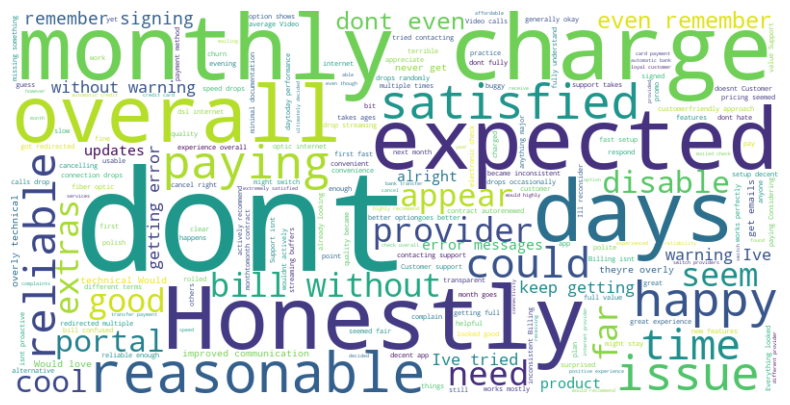

In [42]:
wordcloud_eda(df_eda.customer_feedback)

In [43]:
# check row with "don't" word
df_eda[df_eda.customer_feedback.str.contains('don\'t', case=False, na=False)].head(10)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
49,2954-pibko,female,no,yes,yes,69,yes,yes,dsl,yes,no,two year,yes,credit card (automatic),64.15,4254.10,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
56,8769-kktph,female,no,yes,yes,63,yes,yes,fiber optic,yes,yes,one year,yes,credit card (automatic),99.65,6311.20,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
66,8627-zygsz,male,no,yes,no,47,yes,yes,fiber optic,no,no,one year,yes,electronic check,78.90,3650.35,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
72,1891-qrqsa,male,yes,yes,yes,64,yes,yes,fiber optic,yes,yes,two year,yes,bank transfer (automatic),111.60,7099.00,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
111,4549-zdqyy,female,no,no,no,52,yes,no,dsl,yes,no,one year,no,credit card (automatic),57.95,3042.25,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
155,6551-gnydg,female,no,yes,yes,14,yes,no,fiber optic,no,no,month-to-month,yes,bank transfer (automatic),80.90,1152.80,0,"i have been a customer with this company for 14 months now and i am very satisfied with the service. the fiber optic internet is fast and reliable, and i have had no issues with connectivity. the automatic bank transfer payment method is convenient for me as i don't have to worry about remembering to pay my bill each month. the monthly charges of $80.9 are reasonable for the quality of service i am receiving. overall, i have had a positive experience and would recommend this company to others."
190,7100-fqprv,male,no,yes,yes,43,yes,yes,dsl,yes,no,one year,yes,credit card (automatic),71.90,3173.35,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
205,7674-ytafd,female,no,no,no,33,yes,no,fiber optic,no,no,one year,yes,bank transfer (automatic),79.95,2684.85,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
259,5046-nuhwd,female,yes,yes,no,29,no,no phone service,dsl,yes,no,month-to-month,yes,electronic check,45.00,1228.65,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
333,0122-oahpz,female,no,no,no,7,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,73.85,511.25,1,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."


Explanation:

Based on the word cloud of all customers, most of our customers have great experiences and are happy with our services, but the "don't" words have a quite large proportion on the data. After we check the context for this word, it means that the customer experiencing a negative experience. They don't like the auto contract renewal that comes with different terms. We need to evaluate on terms that we applied on how customer contract renewal works.

### P. Churned Customers Word Cloud and Top 10 Words

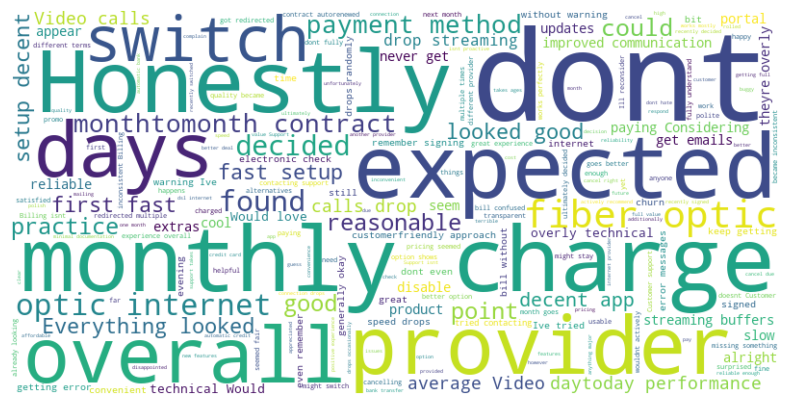

In [44]:
# filter so it is only churned customer
df_churn = df_eda[df_eda.churn == 1]

# visualise wordcloud
wordcloud_eda(df_churn.customer_feedback)

In [45]:
# create function for top words
def top_words(text):
    # join string data
    text = " ".join(text.astype(str))

    # lowercase letter
    text = text.lower()

    # remove hashtag
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # remove non-alphabetic
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # words tokenization
    words = text.split()

    # delete stopwords
    filtered_words = [word for word in words if word not in stop_words_en]

    # count word frequency
    word_c = Counter(filtered_words)

    # create top 10 words
    top_10 = word_c.most_common(10)
    words, count = zip(*top_10)

    # create dataframe for top 10 words
    top10 = pd.DataFrame({'Words': words, 'Frequency': count})

    # create visualisation
    plt.figure(figsize = (12,8))
    sns.barplot(top10, x = 'Words', y = 'Frequency', palette = 'cubehelix')
    plt.title('Top 10 Words')

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\2219767021.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(top10, x = 'Words', y = 'Frequency', palette = 'cubehelix')


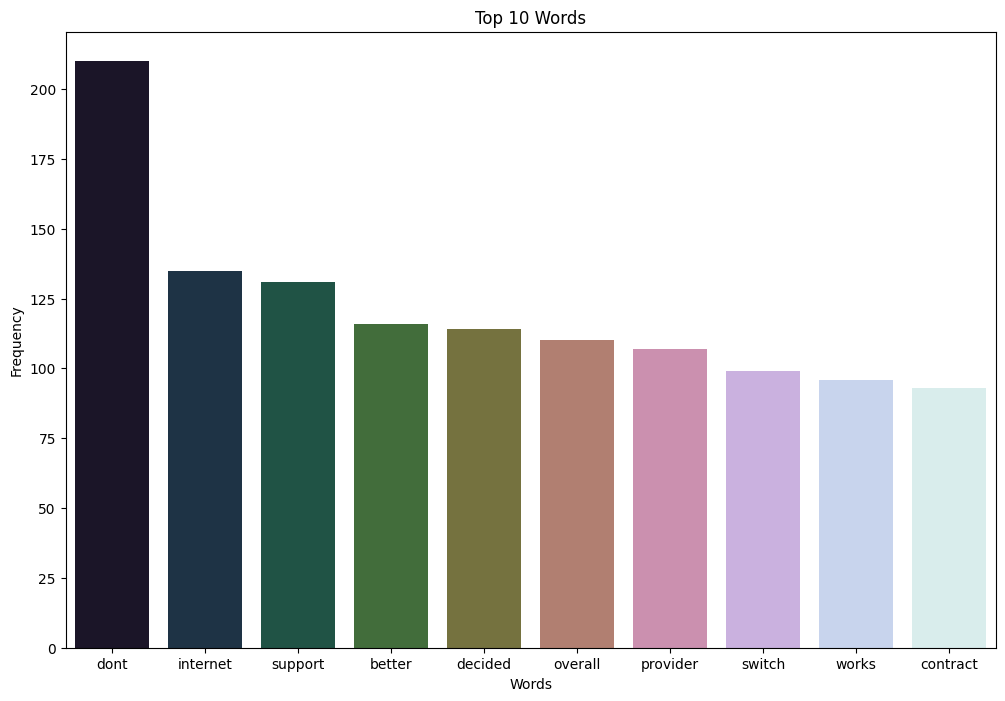

In [46]:
# visualise barchart for churned customer
top_words(df_churn.customer_feedback)

In [47]:
# check feedback contain word "don't" for churned customers
df_churn[df_churn.customer_feedback.str.contains('better', case=False, na=False)].head(10)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
5,9305-cdskc,female,no,no,no,8,yes,yes,fiber optic,no,yes,month-to-month,yes,electronic check,99.65,820.50,1,"At first I was happy, but over time the quality became inconsistent. Billing isn’t very transparent and I was charged for things I don’t fully understand. I might stay if the next month goes better, but honestly I’m already looking at alternatives."
131,6207-wiolx,female,no,yes,yes,25,no,no phone service,dsl,yes,yes,month-to-month,yes,credit card (automatic),58.60,1502.65,1,"i had been a customer with this company for 25 months on a month-to-month contract with a monthly charge of $58.6 for dsl internet service. i had set up automatic credit card payments for convenience. despite being a long-time customer, i ultimately decided to churn because i found a better deal with another provider. the service itself was reliable, but the pricing just wasn't competitive enough for me to stay. i would consider coming back in the future if they were able to offer a better rate."
151,3874-eqoep,male,no,no,no,7,yes,yes,fiber optic,no,yes,month-to-month,no,mailed check,95.00,655.50,1,"i was a customer with this company for 7 months on a month-to-month contract. i chose to pay my $95.0 monthly charges by mailing a check. unfortunately, i ultimately decided to churn as i found a better deal with another provider. the fiber optic internet service was reliable during my time with the company, but ultimately the cost was a deciding factor in my decision to leave. i would recommend this company to others looking for a reliable internet service, but would caution them to compare prices with other providers to ensure they are getting the best deal."
173,0691-jvsya,female,no,yes,no,53,yes,no,fiber optic,no,yes,one year,yes,bank transfer (automatic),94.85,5000.20,1,"i have been a customer with this company for 53 months and have been using their fiber optic internet service. i have been satisfied with the service itself, as the speeds have been consistent and reliable. however, i recently decided to churn because i found a better deal with another provider. the monthly charges of $94.85 were reasonable for the service provided, but i ultimately chose to switch due to a more competitive offer. the automatic bank transfer payment method was convenient and hassle-free. overall, i had a positive experience with this company, but decided to leave for a better deal."
333,0122-oahpz,female,no,no,no,7,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,73.85,511.25,1,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
335,4322-rcymt,male,no,yes,yes,68,yes,yes,dsl,no,no,one year,yes,bank transfer (automatic),75.80,5293.95,1,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
433,2957-lolho,male,no,no,no,12,yes,no,dsl,no,no,month-to-month,yes,bank transfer (automatic),45.40,518.90,1,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
519,3506-lcjdc,male,no,yes,yes,1,yes,no,no,no internet service,no internet service,month-to-month,no,bank transfer (automatic),19.95,19.95,1,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
557,8063-g

In [48]:
# check feedback contain word "overall" for churned customers
df_churn[df_churn.customer_feedback.str.contains('overall', case=False, na=False)].head(20)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
13,0280-xjgex,male,no,no,no,49,yes,yes,fiber optic,no,yes,month-to-month,yes,bank transfer (automatic),103.70,5036.30,1,"i recently decided to switch internet providers after being with my previous provider for almost four years. while the fiber optic internet service was reliable and fast, the monthly charges of $103.70 were a bit steep for me, especially since i was on a month-to-month contract. the automatic bank transfer payment method was convenient, but ultimately i decided to shop around for a more cost-effective option. overall, i had a positive experience with the service itself, but the pricing ultimately led me to churn."
117,5299-ruloa,female,no,yes,yes,10,yes,yes,fiber optic,yes,yes,month-to-month,yes,electronic check,100.25,1064.65,1,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
171,1875-qivme,female,no,yes,no,2,yes,yes,fiber optic,no,yes,month-to-month,yes,electronic check,104.40,242.80,1,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
173,0691-jvsya,female,no,yes,no,53,yes,no,fiber optic,no,yes,one year,yes,bank transfer (automatic),94.85,5000.20,1,"i have been a customer with this company for 53 months and have been using their fiber optic internet service. i have been satisfied with the service itself, as the speeds have been consistent and reliable. however, i recently decided to churn because i found a better deal with another provider. the monthly charges of $94.85 were reasonable for the service provided, but i ultimately chose to switch due to a more competitive offer. the automatic bank transfer payment method was convenient and hassle-free. overall, i had a positive experience with this company, but decided to leave for a better deal."
290,7534-bfesc,male,yes,no,no,24,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,76.10,1712.70,1,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
317,2321-ombxy,female,no,yes,yes,38,yes,no,dsl,yes,yes,one year,no,credit card (automatic),80.30,3058.65,1,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
354,0623-iihug,female,yes,no,no,21,no,no phone service,dsl,yes,yes,month-to-month,yes,electronic check,41.90,840.10,1,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
537,0378-tovms,female,no,no,no,3,yes,no,fiber optic,no,no,month-to-month,no,electronic check,85.80,272.20,1,"yments. overall, i would not recommend this service to others and will be looking for a more reliable internet provider."
637,7817-boqpw,female,no,no,no,2,yes,yes,fiber optic,no,no,month-to-month,yes,electronic check,75.55,166.30,1,"""after only 2 months of using the fiber optic internet service, i decided to cancel due to ongoing technical issues and unreliable connection. despite the relatively high monthly charges of $75.55, the service did 

Explanation:

Based on wordcloud, we can see that the tokens "don't", "monthly charge", and "switch" frequently appear. It means that customers often talk about Telco monthly charges and the tendency to switch providers and leave the company. From the top 10 words that frequently appear on feedback from churned customers, we can see that the words "don't" are the most frequently appear on feedback from churned customers. If we look at the feedback that contains the word "don't", most of the customers feel not satisfied with auto contract renewal with different terms. The word "overall" is also in the top 10. Most of the feedback that contains the word "overall" has a mixed sentiment explaining customer experience when using our service. There's a strange word in the top 10, and that word is "better". That word is supposed to have a tendency to have positive sentiment, but here that word has a tendency towards switching to a better provider.

We can conclude that we need to improve our auto contract renewal terms and improve our services.

### Q. Retained Customers Word cloud and Top 10 Words

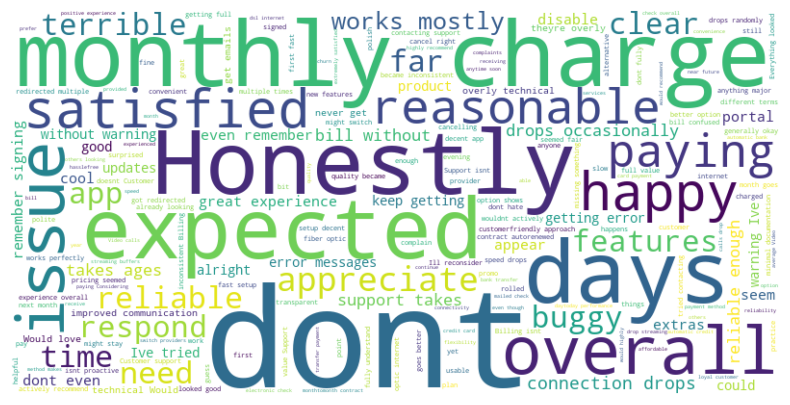

In [49]:
# filter by retained customers
df_retain = df_eda[df_eda.churn == 0]

# visualise wordcloud
wordcloud_eda(df_retain.customer_feedback)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13692\2219767021.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(top10, x = 'Words', y = 'Frequency', palette = 'cubehelix')


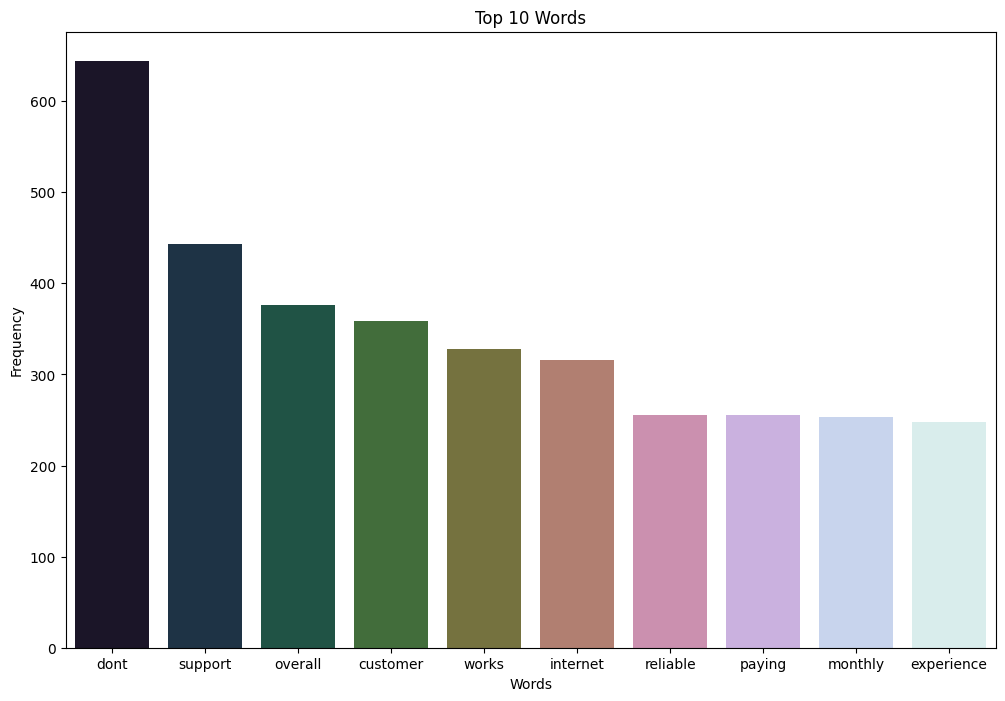

In [50]:
# visualise barchar for retained customers
top_words(df_retain.customer_feedback)

In [51]:
# check feedback contain word "don't" for churned customers
df_retain[df_retain.customer_feedback.str.contains('don\'t', case=False, na=False)].head(10)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
49,2954-pibko,female,no,yes,yes,69,yes,yes,dsl,yes,no,two year,yes,credit card (automatic),64.15,4254.10,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
56,8769-kktph,female,no,yes,yes,63,yes,yes,fiber optic,yes,yes,one year,yes,credit card (automatic),99.65,6311.20,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
66,8627-zygsz,male,no,yes,no,47,yes,yes,fiber optic,no,no,one year,yes,electronic check,78.90,3650.35,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
72,1891-qrqsa,male,yes,yes,yes,64,yes,yes,fiber optic,yes,yes,two year,yes,bank transfer (automatic),111.60,7099.00,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
111,4549-zdqyy,female,no,no,no,52,yes,no,dsl,yes,no,one year,no,credit card (automatic),57.95,3042.25,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
155,6551-gnydg,female,no,yes,yes,14,yes,no,fiber optic,no,no,month-to-month,yes,bank transfer (automatic),80.90,1152.80,0,"i have been a customer with this company for 14 months now and i am very satisfied with the service. the fiber optic internet is fast and reliable, and i have had no issues with connectivity. the automatic bank transfer payment method is convenient for me as i don't have to worry about remembering to pay my bill each month. the monthly charges of $80.9 are reasonable for the quality of service i am receiving. overall, i have had a positive experience and would recommend this company to others."
190,7100-fqprv,male,no,yes,yes,43,yes,yes,dsl,yes,no,one year,yes,credit card (automatic),71.90,3173.35,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
205,7674-ytafd,female,no,no,no,33,yes,no,fiber optic,no,no,one year,yes,bank transfer (automatic),79.95,2684.85,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
259,5046-nuhwd,female,yes,yes,no,29,no,no phone service,dsl,yes,no,month-to-month,yes,electronic check,45.00,1228.65,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."
368,9571-edebv,male,no,yes,no,71,yes,yes,fiber optic,no,yes,one year,yes,credit card (automatic),98.65,6962.85,0,"I signed up because of a promo, and the pricing seemed fair. But then the contract auto-renewed with different terms. The service itself is fine, but I don't like being surprised. I might switch if a better option shows up."


In [52]:
# check feedback contain word "overall" for churned customers
df_retain[df_retain.customer_feedback.str.contains('overall', case=False, na=False)].head(30)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
15,3655-snqyz,female,no,yes,yes,69,yes,yes,fiber optic,yes,yes,two year,no,credit card (automatic),113.25,7895.15,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
42,9867-jczsp,female,no,yes,yes,17,yes,no,no,no internet service,no internet service,one year,no,mailed check,20.75,418.25,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
79,3887-pbqao,female,no,yes,yes,45,yes,yes,no,no internet service,no internet service,one year,yes,credit card (automatic),25.90,1216.60,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
105,6180-ybiqi,male,no,no,no,5,no,no phone service,dsl,no,no,month-to-month,no,mailed check,24.30,100.20,0,"i have been a customer with this company for 5 months now and i have been very satisfied with the dsl internet service they provide. the monthly charges are very reasonable at $24.3 and i appreciate the flexibility of the month-to-month contract. i also prefer paying by mailed check and the process has been smooth so far. overall, i have had a positive experience with this company and i have no plans to churn anytime soon."
108,8597-cwyhh,male,no,no,no,43,yes,yes,fiber optic,no,yes,one year,no,mailed check,94.35,3921.30,0,"""i have been a loyal customer with this company for over three and a half years now and have been very satisfied with their fiber optic internet service. the speed and reliability have been excellent, and i have had no issues with connectivity. the monthly charges are reasonable for the quality of service provided. i appreciate being able to pay by mailed check as it is convenient for me. overall, i have no complaints and would highly recommend this company to others."""
123,6497-tilvl,female,no,yes,yes,7,yes,no,dsl,yes,no,month-to-month,no,mailed check,50.70,350.35,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
124,7219-tlzho,female,no,yes,yes,4,yes,no,no,no internet service,no internet service,month-to-month,no,mailed check,20.85,62.90,0,"i have been a customer with this company for 4 months now on a month-to-month contract. i do not have internet service with them, so my monthly charges are $20.85. i prefer to pay by mailed check. overall, i have had a positive experience so far and have not experienced any issues with the service. i appreciate the simplicity of the payment process and the affordable monthly charges. i have no plans to cancel my service with this company."
145,5716-ezxzn,female,no,yes,yes,65,yes,yes,fiber optic,yes,yes,two year,yes,credit card (automatic),99.05,6416.70,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
155,6551-gnydg,female,no,yes,yes,14,yes,no,fiber optic,no,no,month-to-month,yes,bank transfer (automatic),80.90,1152.80,0,"i have been a customer with this company for 14 months now and i am very satisfi

In [53]:
# check feedback contain word "support" for churned customers
df_retain[df_retain.customer_feedback.str.contains('support', case=False, na=False)].head(10)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,streaming_tv,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_feedback
10,9763-grskd,male,no,yes,yes,13,yes,no,dsl,yes,no,month-to-month,yes,mailed check,49.95,587.45,0,"I don’t have anything major to complain about, but I also don’t feel like I’m getting full value. Support isn’t proactive and new features are rolled out with minimal documentation. I guess I expected a bit more polish."
15,3655-snqyz,female,no,yes,yes,69,yes,yes,fiber optic,yes,yes,two year,no,credit card (automatic),113.25,7895.15,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
32,6827-ieauq,female,no,yes,yes,27,yes,no,dsl,yes,no,one year,no,mailed check,66.15,1874.45,0,"It’s usable, but far from great. Some days it works perfectly, other days it doesn’t. Customer support is polite but slow. I wouldn’t actively recommend it to anyone, but I also don’t hate it enough to cancel right now."
42,9867-jczsp,female,no,yes,yes,17,yes,no,no,no internet service,no internet service,one year,no,mailed check,20.75,418.25,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
57,5067-xjqfu,male,yes,yes,yes,66,yes,yes,fiber optic,no,yes,one year,yes,electronic check,108.45,7076.35,0,"I don’t have anything major to complain about, but I also don’t feel like I’m getting full value. Support isn’t proactive and new features are rolled out with minimal documentation. I guess I expected a bit more polish."
58,3957-sqxml,female,no,yes,yes,34,yes,yes,no,no internet service,no internet service,two year,no,credit card (automatic),24.95,894.30,0,"Service works, mostly. The connection drops occasionally and support takes ages to respond. The app is buggy and it’s not clear what features I’m paying for. It’s not terrible, just not reliable enough for what I need day to day."
68,3170-nmyvv,female,no,yes,yes,50,yes,no,no,no internet service,no internet service,two year,no,bank transfer (automatic),20.15,930.90,0,"Service works, mostly. The connection drops occasionally and support takes ages to respond. The app is buggy and it’s not clear what features I’m paying for. It’s not terrible, just not reliable enough for what I need day to day."
79,3887-pbqao,female,no,yes,yes,45,yes,yes,no,no internet service,no internet service,one year,yes,credit card (automatic),25.90,1216.60,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."
98,3212-kxocr,male,no,no,no,52,yes,no,no,no internet service,no internet service,two year,no,bank transfer (automatic),21.00,1107.20,0,"Service works, mostly. The connection drops occasionally and support takes ages to respond. The app is buggy and it’s not clear what features I’m paying for. It’s not terrible, just not reliable enough for what I need day to day."
123,6497-tilvl,female,no,yes,yes,7,yes,no,dsl,yes,no,month-to-month,no,mailed check,50.70,350.35,0,"I’ve been using the service for a while and it’s generally okay, but I feel like the speed drops randomly in the evening. I tried contacting support once but got redirected multiple times. Not a great experience overall, but I’m still using it… for now."


Explanation:

Based on the word cloud of retained customers, most of the feedback is positive, except the word "don't" that frequently appeared. We take a look at the top 10 words that frequently appeared in customer feedback, and we can see that the words "don't", "overall", and "support" frequently appeared in the feedback. 

Most of the feedback that contains the word "don't" has the same meaning as the word "don't" that appeared on most feedback from churned customers. Most of the feedback that contains the word "overall" has mixed sentiment. Customers with positive feedback often praise the quality of internet service and reasonable monthly payments. Customers with negative feedback often complain about the speed of the internet services and the lack of support from customer service. Most feedback that contains the word "support" from retained customers often complains about the quality of customer service.

We can conclude that we need to improve the quality of our customer service, internet speed, and terms of contract renewal. Our customer retention can be worse if we don't overcome these problems.